In [17]:
!pip install matplotlib pandas filterpy tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [15]:
import os
import sys

current_dir = os.path.dirname(os.path.abspath('filter_sandbox.ipynb'))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from kalman_filter_bank.kalman_filter import SinusoidalKalmanFilter
from kalman_filter_bank.filter_bank import SinusoidalCMMEAFilterBank, run_filter_bank

## Read in Data

In [23]:
def read_data():
    # load in the price data
    data_df = pd.read_csv('../data/btc_1m.csv')
    # compute the rate of return -- makes the price easier to track
    data_df['rate'] = (data_df['Open'].values - data_df['Open'].values[0]) / data_df['Open'].values[0]
    return data_df

df = read_data()
df.head()

,Date,Time,EpochTime,Open,High,Low,Close,Volume,rate
0,2025-07-31,02:15:00Z,1753928100,118230.01,118230.01,118200.01,118230.01,3.583388,0.000000
1,2025-07-31,02:16:00Z,1753928160,118230.01,118238.45,118215.00,118219.28,1.053575,0.000000
2,2025-07-31,02:17:00Z,1753928220,118219.32,118269.64,118215.00,118262.50,1.593586,-0.000090
3,2025-07-31,02:18:00Z,1753928280,118262.50,118267.98,118262.50,118267.98,0.337689,0.000275
4,2025-07-31,02:19:00Z,1753928340,118267.98,118267.98,118238.47,118242.06,0.522006,0.000321


# Test One Sinusoidal Kalman Filter

Input Args:

dim_x: number of filter states to model; for the SKF, we're modeling position and velocity

dim_z: number of measurements states; for the SKF, we're only measuring position

omega: frequency term whose amplitude and phase we are estimating

dt: change in time between samples

sigma_xi: scalar of the Q matrix. Note, the HIGHER this value, the LESS the filter trusts its ESTIMATION

rho: scalar of the R matrix. Note, the HIGHER this value, the LESS the filter trusts its MEASUREMENTS

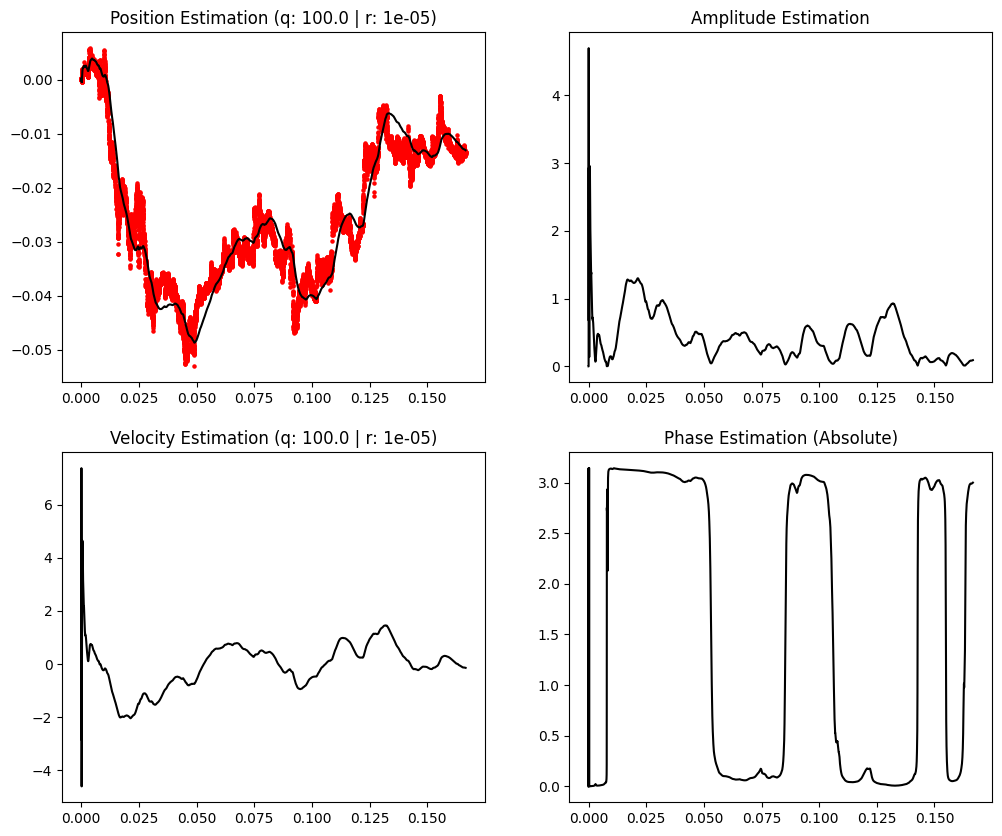

In [20]:
def plot_filter(meas, x_history, amp_phase, dt):
    t = np.arange(0, len(measurements)*dt, dt)
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs[0, 0].scatter(t, measurements, color='red', s=5)
    axs[0, 0].plot(t, x_history[:, 0], color='k')
    axs[0, 0].set_title(f'Position Estimation (q: {q_scalar} | r: {r_scalar})')

    axs[1, 0].plot(t, x_history[:, 1], color='k')
    axs[1, 0].set_title(f'Velocity Estimation (q: {q_scalar} | r: {r_scalar})')

    axs[0, 1].plot(t, amp_phase[:, 0], color='k')
    axs[0, 1].set_title(f'Amplitude Estimation')

    axs[1, 1].plot(t, np.abs(amp_phase[:, 1]), color='k')
    axs[1, 1].set_title(f'Phase Estimation (Absolute)')

# build the filter
omega = 2*np.pi*.25
dt = 1/(60*60*24)  # number of minutes in a day
q_scalar = 1e2
r_scalar = 1e-5
skf = SinusoidalKalmanFilter(2, 1, omega, dt, sigma_xi=q_scalar, rho=r_scalar)

# run the filter
measurements = df.rate.values.reshape(-1, 1)
x_history = np.zeros((measurements.shape[0], 2))
amp_phase = np.zeros((measurements.shape[0], 2))
for i in range(len(measurements)):
    # get the measurement
    z = measurements[i]

    # update the kalman filter
    skf.update(z)
    skf.predict()

    # store the filter
    x_history[i] = skf.x
    amp_phase[i, :] = (skf.amplitude(), skf.phase())

# plot the filter
plot_filter(measurements, x_history, amp_phase, dt)

# Test Sinusoidal Filter Bank w/ CMMEA Combinator

Running the Filter Bank for 14400 steps


100%|██████████| 14400/14400 [00:07<00:00, 1867.28it/s]


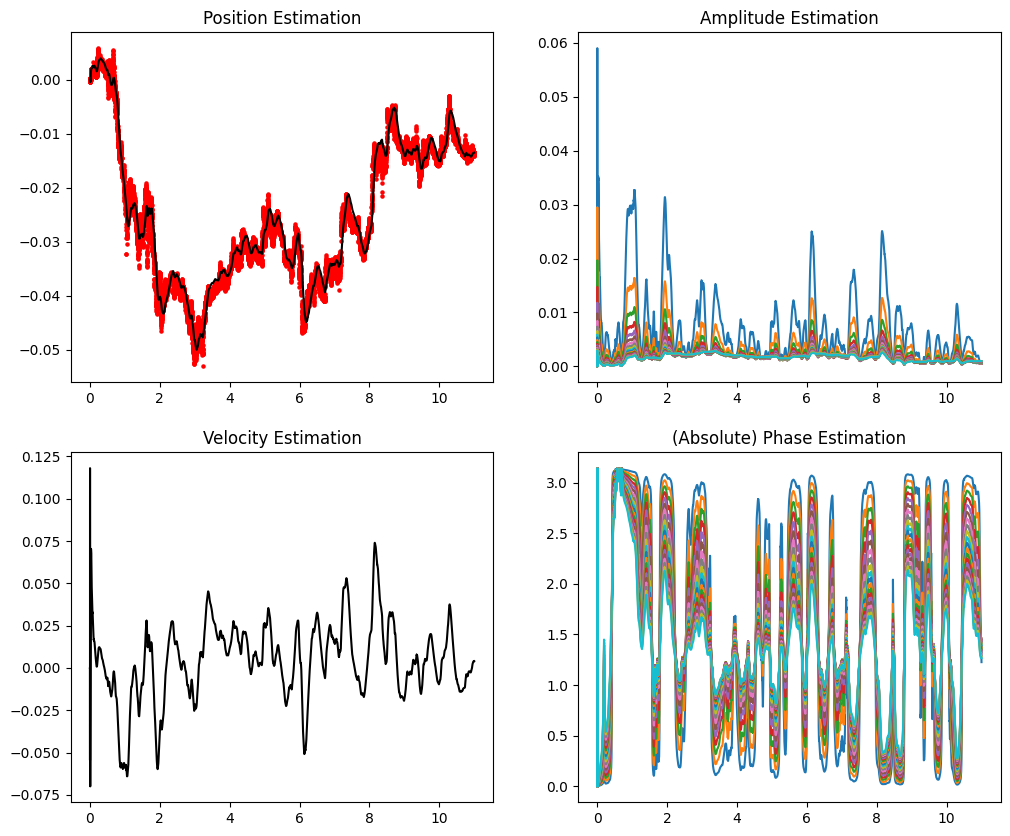

In [21]:
def plot_filter_bank(meas, bank_dict, dt):
    # extract values
    bank_x = bank_dict['x']
    amp = bank_dict['amp']
    phase = bank_dict['phi']

    # plot filter estimates and system dynamics
    t = np.arange(0, len(meas)*dt, dt)
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs[0, 0].scatter(t, meas, color='red', s=5)
    axs[0, 0].plot(t, bank_x[:, 0], color='k')
    axs[0, 0].set_title(f'Position Estimation')

    axs[1, 0].plot(t, bank_x[:, 1], color='k')
    axs[1, 0].set_title(f'Velocity Estimation')


    axs[0, 1].plot(t, amp * cmmea_dict['w'])
    axs[0, 1].set_title(f'Amplitude Estimation')

    axs[1, 1].plot(t, np.abs(phase))
    axs[1, 1].set_title(f'(Absolute) Phase Estimation')

# build the CMMEA
d_omega = .1
omega_arr = np.arange(d_omega, 2+d_omega, d_omega)
cmmea_sigXi = [1e1]*len(omega_arr)
cmmea_rho = [1e-2]*len(omega_arr)
dt_cmmea = len(df.Date.unique()) / len(df)
cmmea = SinusoidalCMMEAFilterBank(2, 1, omegas=omega_arr, dt=dt_cmmea, sigma_xi=cmmea_sigXi, rho=cmmea_rho)

# run the CMMEA
cmmea_dict = run_filter_bank(cmmea, measurements)
plot_filter_bank(measurements, cmmea_dict, dt_cmmea)

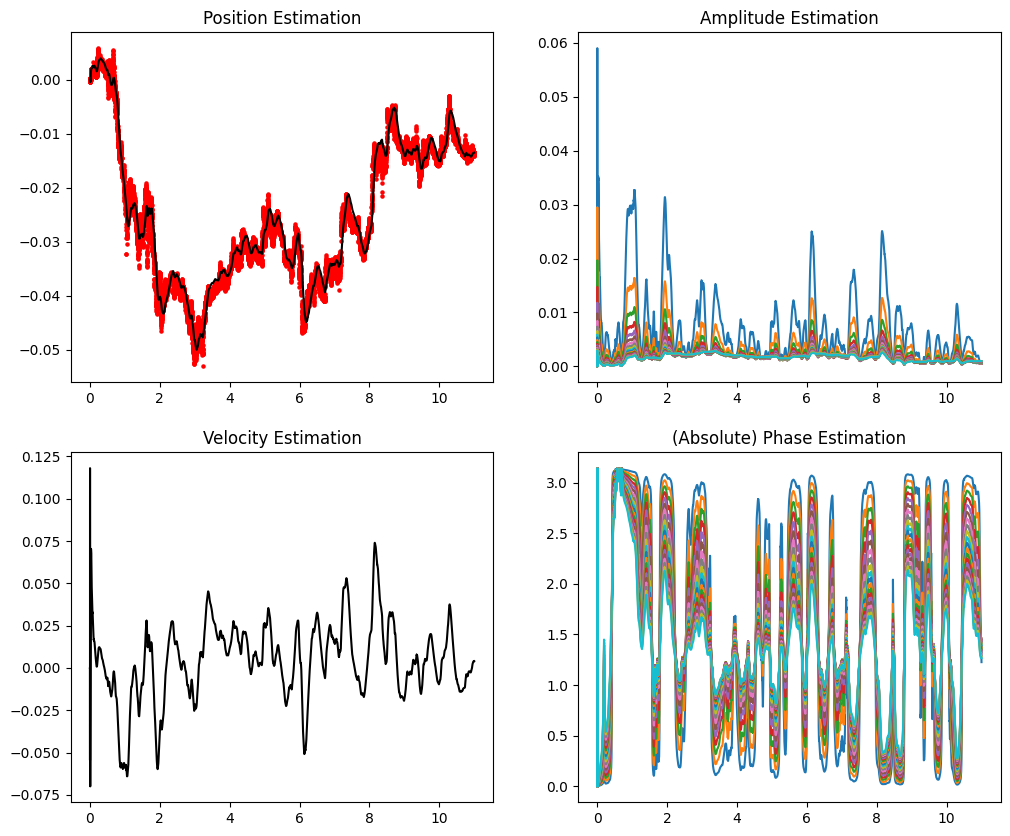

In [22]:
plot_filter_bank(measurements, cmmea_dict, dt_cmmea)